# ComputeFramework

Low-level view:

**ComputeFramework *reorganizes* your computation so that it can be:**
  - out-of-core
  - parallel
  
  
High-level view:

- Array library
- Other data-parallel libraries

ComputeFramework is similar to [Dask](http://dask.pydata.org).

In [ ]:
Pkg.clone("git://github.com/shashi/ComputeFramework.jl.git")

## Out-of-core
Out-of-core computation means working with data which does not fit in the RAM. Let's find out how much RAM we have left. `Sys.free_memory()` can tell you this.

In [1]:
Int(Sys.free_memory())/10^9

3.270762496

In [2]:
rand(10^9)

LoadError: LoadError: OutOfMemoryError()
while loading In[2], in expression starting on line 1

In [3]:
io = open("/tmp/mybigarray", "w+")
X = Mmap.mmap(io, Vector{Float64}, (10^9,))
close(io)

In [4]:
@time rand!(X)

 32.002616 seconds (352 allocations: 54.717 KB)


1000000000-element Array{Float64,1}:
 0.267742 
 0.443058 
 0.624259 
 0.638633 
 0.556649 
 0.8985   
 0.293189 
 0.910657 
 0.720193 
 0.229968 
 0.904033 
 0.243382 
 0.885413 
 ⋮        
 0.49157  
 0.688918 
 0.996498 
 0.380882 
 0.0925714
 0.973726 
 0.772788 
 0.987345 
 0.650068 
 0.924893 
 0.864534 
 0.136137 

Let's try to do something with it.

In [5]:
@time sum(X)

 59.153371 seconds (24.71 k allocations: 1.052 MB)


5.000083993653752e8

But `mmap` quickly stops working...

In [5]:
sum(sin(X).^2 + cos(X).^2)

# results in 8 GB allocation at any given time.

LoadError: LoadError: OutOfMemoryError()
while loading In[5], in expression starting on line 1

In [6]:
rm("/tmp/mybigarray")

### Working with big arrays in ComputeFramework

In [1]:
#Pkg.clone("git://github.com/shashi/ComputeFramework.jl.git")
using ComputeFramework

In [2]:
x_node = rand(BlockPartition(32*10^6), 10^9);

We have not actually created the array `x_node` yet. `x_node` represents a *contract* to create the array.

We can create the array and write it directly to disk using `compute(save(x_node, "/scratch/X"))`. Again, you can think of `save` as returning a *contract* to save its input.

`compute` is the ComputeFramework primitive that actually realizes a contract.

In [3]:
@time X = compute(save(x_node, "/tmp/X"))

 35.310197 seconds (3.90 M allocations: 7.625 GB, 1.01% gc time)


ComputeFramework.Computed(1000000000 Array{Float64,1} in 32 parts)

In [3]:
X = load(Context(), "/tmp/X")

ComputeFramework.Computed(1000000000 Array{Float64,1} in 32 parts)

In [3]:
result = sum(sin(X).^2 + cos(X).^2);

In [6]:
@time compute(result)

 87.842400 seconds (850.18 k allocations: 52.193 GB, 3.16% gc time)


1.0e9

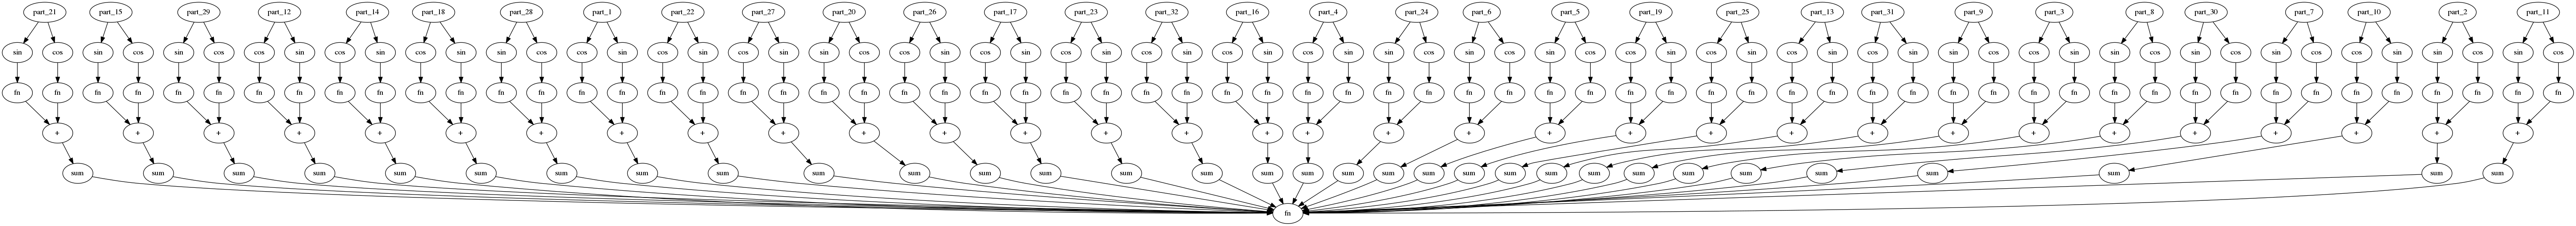

In [5]:
using GraphViz
Graph(show_plan(
    sum(sin(X).^2 + cos(X).^2)
))

In [9]:
X = rand(BlockPartition(100, 100), 300, 200)
y = rand(BlockPartition(100), 300)

ComputeFramework.AllocateArray(Float64,rand,ComputeFramework.DenseDomain{1}((1:300,)),ComputeFramework.BlockPartition{1}((100,)))

In [10]:
using Colors

In [30]:
red = RGB(1,0,0)
blue = RGB(0,0,1)
green = RGB(0,1,0)
white = RGB(1,1,1)

X_blocks = RGB[red for j=1:3, i=1:2];

In [35]:
display(X_blocks')
display(HTML("<h1>*</h1>"))
display(X_blocks)
display(HTML("<h1>=</h1>"))
display(RGB[green for i=1:2, j=1:2])

HTML{ASCIIString}("<h1>*</h1>")

HTML{ASCIIString}("<h1>=</h1>")

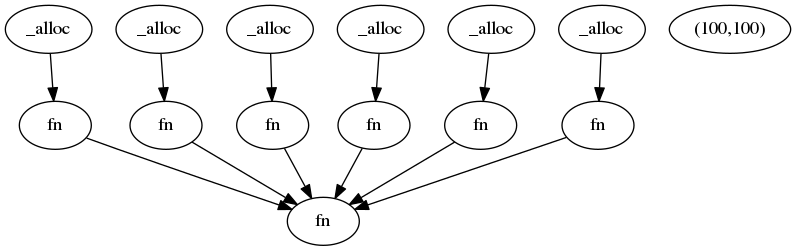

In [11]:
Graph(show_plan(X'))